# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нам необходимопостроить модель для задачи классификации, которая выберет подходящий тариф. 


**Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.**

**Цель исследования** - построение модели с максимально большим значением *accuracy*.

**Задачи исследования**
* Ознакомиться с данными;
* Выделить обучаюшую/валидационную/тестовую выборку;
* Исследовать разные модели(выбрать несколько гиперпараметров);
* Проверить модели на тестовой выборке (выявить модель с лучшим __accuracy__)
* Проверить модели на адекватность.

**Особенности**
- Предобработка данных не понадобится — она уже была сделана заранее.

Каждый ход исследования заканчивается выводом. В конце исследования даётся обощающий вывод по всему исследованию

## Ознакомиться с данными

[Сразу к выводу](#section_id1)

<b>Имортируем необходимые библиотеки</b>

In [2]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from joblib import dump
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.dummy import DummyClassifier

<b>Открываем файл с данными и изучаем общую информацию</b>       

In [3]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('users_behavior.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


**Таблица users_behavior (информация об повведении пользователей):**
- calls - количество сделанных звонков
- minutes - количество использованных минут
- messages - количество отправленных сообщений
- mb_used - количество использованных мгб
- is_ultra - признак (1 - ультра или 0 - смарт)

In [5]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [6]:
df.duplicated().sum()

0

In [7]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

### Краткий вывод по первому шагу.
<a id='section_id1'></a>

Уже знакомая нам таблица. 4 количественных и один категориальный признак. У всех подходящий тип данныз, пустых значений нет. Название столбцов имееет правильное наименование. Дубликатов нет. Можно со спокойной душой переходить к следующему шагу.

<div class="alert alert-block alert-warning">
<b> Посмотрим корреляцию</b>
</div>

In [8]:
df[['calls', 'minutes', 'messages', 'mb_used','is_ultra']].corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


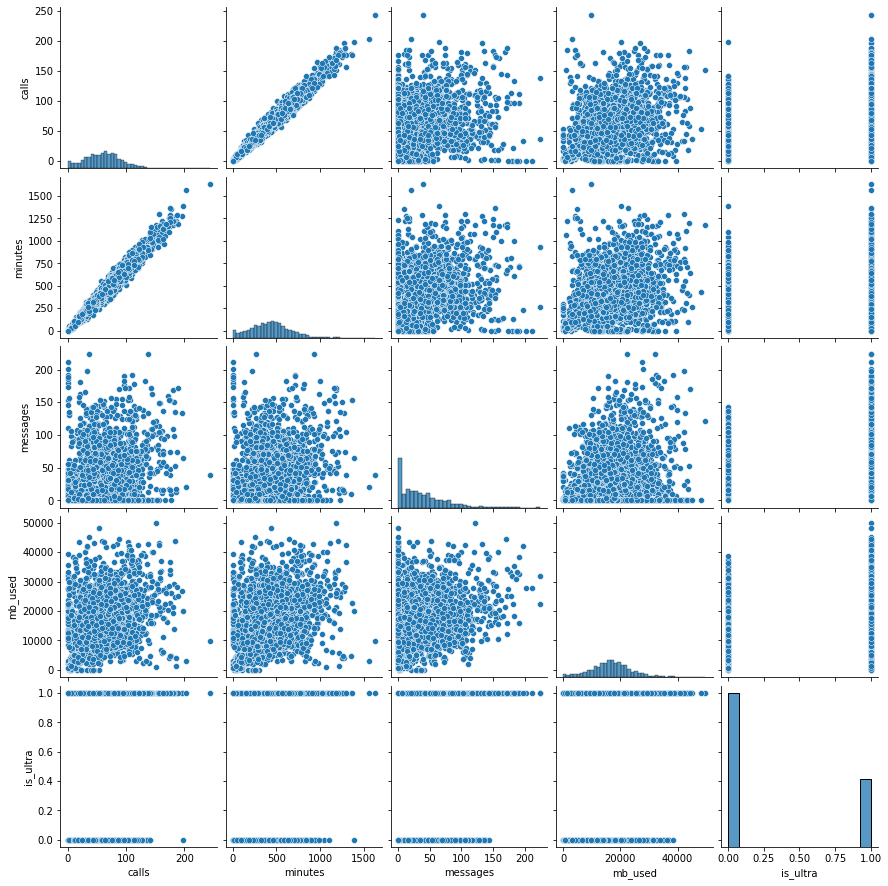

In [9]:
sns.pairplot(df, vars = ['calls', 'minutes', 'messages', 'mb_used','is_ultra'])

### Корреляция в данных.

<div class="alert alert-block alert-warning">
<b>
Наибольшая корреляция прослежвается между calls и minutes оно и в принципе логично, кто чаще звонит говорит больше. В остальных случаях выше 0.30 нет.
</b> 
</div>

## Выделить обучаюшую/валидационную/тестовую выборку

[Сразу к выводу](#section_id2)

В нашем случае, нет отдельного файла с тестовой,тренировочной и валидной выборкой, поэтому мы их будем создавать сами.
Поделим cначала на обучающую и промежуточную, а потом промежуточную поделим на валидную и тестовую.

In [10]:
features_train, features_inter, target_train, target_inter = train_test_split(
    features, 
    target, 
    test_size=0.4, 
    random_state=12345)

Теперь промежуточную поделим пополам

In [11]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_inter,
    target_inter,
    test_size=0.5,
    random_state=12345)

Тренировочная выборка у нас с такой размерностью

In [12]:
features_train.shape

(1928, 4)

In [13]:
features_train

,calls,minutes,messages,mb_used
3027,60.0,431.56,26.0,14751.26
434,33.0,265.17,59.0,17398.02
1226,52.0,341.83,68.0,15462.38
1054,42.0,226.18,21.0,13243.48
1842,30.0,198.42,0.0,8189.53
...,...,...,...,...
2817,12.0,86.62,22.0,36628.85
546,65.0,458.46,0.0,15214.25
382,144.0,906.18,0.0,25002.44
2177,38.0,301.27,37.0,28914.24


Тестовая и валидная такая:

In [99]:
features_valid.shape

(643, 4)

### Краткий вывод по второму шагу.
<a id='section_id2'></a>

В следствии того, что у нас только один файл(а не три), мы его честно поделили на три части. Сначала общую поделили на тестовую и промежуточную. Поделили в соотношении 40/60. Всё таки учебная выборка должна быть больше остальных.
Далее промежуточную поделили пополам - на валидную и тестовую.

## Исследовать разные модели(выбрать несколько гиперпараметров)

[Сразу к выводу](#section_id3)

Так как в нашем случае, стоит задача на классификацию, то наш выбор будет ограничиваться вот такими моделями:

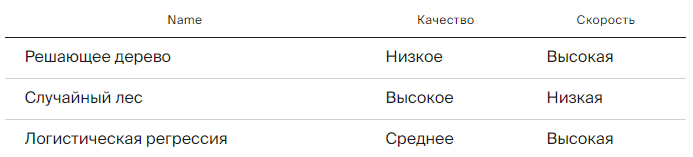

#### Дерево решений в регрессии.

Попробуем подобрать максимальную глубину.

In [14]:
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth) # обучите модель с заданной глубиной дерева
    model.fit(features_train,target_train) # обучите модель
    predictions_valid = model.predict(features_valid) # получите предсказания модели
    result = accuracy_score(target_valid, predictions_valid) # посчитайте качество модели
    print('max_depth =', depth, ':', result)
    print(accuracy_score(target_valid, predictions_valid)) 

max_depth = 1 : 0.7542768273716952
0.7542768273716952
max_depth = 2 : 0.7822706065318819
0.7822706065318819
max_depth = 3 : 0.7853810264385692
0.7853810264385692
max_depth = 4 : 0.7791601866251944
0.7791601866251944
max_depth = 5 : 0.7791601866251944
0.7791601866251944
max_depth = 6 : 0.7838258164852255
0.7838258164852255
max_depth = 7 : 0.7822706065318819
0.7822706065318819
max_depth = 8 : 0.7791601866251944
0.7791601866251944
max_depth = 9 : 0.7822706065318819
0.7822706065318819


Увеличивая глубину - точность не растёт. Модель переобучается => на тестовой выйдет лажа.
Сделаем вывод, что **лучшая глубина для данной модели - 3.**

<div class="alert alert-block alert-warning">
<b>
Попробуем использовать GreedSeacrhCV для дерева решений
</b> 
</div>    

In [15]:
model = DecisionTreeClassifier(random_state=12345)
    

param_dict = {'max_depth': range(1, 10)}

grid = GridSearchCV(model, param_dict, cv = 5, scoring='accuracy', n_jobs = -1)

grid.fit(features_train, target_train)
grid.best_score_

0.8018706681919119

In [102]:
grid.best_estimator_

DecisionTreeClassifier(max_depth=3, random_state=12345)


<div class="alert alert-block alert-warning">
<b>
Результат даже выше, чем при ручной подборке, хотя лучшее значения глубины также - 3
</b> 
</div>

#### Случайный лес в регрессии.

Подберем гиперпараметры по максимальной глубине леса и количеству деревьев и минимальному количество примеров для разделения.

ЗЫ. работает долго у меня минуты 2 думало. Помните - __терпение - это благодетель__.

In [103]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 101, 10):
    for sample in range(2,5):
        for depth in range (1, 11):
            model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, min_samples_split = sample)
            model.fit(features_train, target_train) 
            predictions_valid = model.predict(features_valid)
            result = accuracy_score(target_valid, predictions_valid) 
            if result > best_result:
                best_model = model
                best_result = result
                best_est = est
                best_depth = depth
                best_split = sample


print("accuracy наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth, "минимальное количество примеров для разделения",best_split)

accuracy наилучшей модели на валидационной выборке: 0.8102643856920684 Количество деревьев: 40 Максимальная глубина: 10 минимальное количество примеров для разделения 4


<div class="alert alert-block alert-warning">
<b>
Попробуем использовать для случайного леса RandomizedSearchCV
</b> 
</div>

In [104]:
model = RandomForestClassifier(random_state=12345)
    

param_dict = {'max_depth': range(1, 10),
             'n_estimators': range(10, 201, 10),
             'min_samples_split': range(2,5)}

grid = RandomizedSearchCV(model, param_dict, cv = 5, scoring='accuracy', n_jobs = -1)

grid.fit(features_train, target_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(1, 10),
                                        'min_samples_split': range(2, 5),
                                        'n_estimators': range(10, 201, 10)},
                   scoring='accuracy')

In [105]:
grid.best_estimator_

RandomForestClassifier(max_depth=9, min_samples_split=3, n_estimators=130,
                       random_state=12345)

In [106]:
grid.best_score_


0.820030953502456

<div class="alert alert-block alert-warning">
<b>
Значние выше того, что мы получили ранее.
</b> 
</div>

#### Логистическая регрессия

In [107]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
model.fit(features_train, target_train) 
result = model.score(features_valid, target_valid)


print("Accuracy наилучшей модели на валидационной выборке:", result)

Accuracy наилучшей модели на валидационной выборке: 0.7107309486780715


### Краткий вывод по третьему шагу.
<a id='section_id3'></a>

Мы проверили три модели - (Дерево решений в регрессии, Случайный лес в регрессии и Логистическая регрессия).
* Для дерева решений, мы решили подобрать гиперпараметр - глубина дерева. По результатам выявили, что это значение - 3.
* Для случайного леса, мы пошли глубже и посчитали максимальной глубины еще и количество деревьев. Результат - 10 и 40.
* Для логистической(как и для остальных моделей) мы обязательным условием прописывали random_state=12345, чтобы усложнить работу моделей и улучшить их достоверность.

По предварительным прогонам (на тренировочной и валидационной выборке) лучший результат показала себя модель **случайного леса**. Acuuracy не то, что не меньше 0.75, а даже **0.80**
Далее следует **дерево решений** с аcuuracy **0.78** и **логистическая** с **0.71**.
Осталось проверить модели на тестовых выборках. Чем мы займемся в следующем шаге.

### Краткий вывод по третьему шагу. (RandomizedSearchCV,GreedSeacrhCV)

При использовании GreedSeacrhCV мы получили значение accuracy даже выше, чем при ручном подборе гиперпараметров, что странно ибо у нас также лучшая глубина - 3

При использовании RandomizedSearchCV мы получили значения гиперпараметров даже улучшающих значения модели.

## Проверить модели на тестовой выборке (выявить модель с лучшим __accuracy__)

[Сразу к выводу](#section_id4)

Проверим на тестовой выборке предварительного серебряного медалиста наего исследования - **дерево решений**

<div class="alert alert-block alert-warning">
<b>
Объединим обучающую и валидационную выборку для лучшего обучения моделей и улучшения качества.
</b> 
</div>

In [108]:
features_all = [features_train, features_valid]
target_all = [target_train,target_valid ]
features_train = pd.concat(features_all, sort=False)
target_train = pd.concat(target_all, sort=False)

In [109]:
model_dtc = DecisionTreeClassifier(random_state=12345, max_depth = 3) # обучите модель с заданной глубиной дерева
model_dtc.fit(features_train,target_train) # обучите модель
predictions_test_dtc = model_dtc.predict(features_test) # получите предсказания модели
result_dtc = accuracy_score(target_test, predictions_test_dtc) # посчитайте качество модели
result_dtc

0.776049766718507

Проверим на тестовой выборке промежуточного лидера - **случайный лес**

In [110]:
model_rfc = RandomForestClassifier(random_state=12345, n_estimators=190 , max_depth=9, min_samples_split = 4)
model_rfc.fit(features_train, target_train) 
predictions_test_rfc = model_rfc.predict(features_test)
result_rfc = accuracy_score(target_test, predictions_test_rfc) 
result_rfc

0.8040435458786936

Проверим на тестовой выборке аутсайдера - **логическую регрессию**

In [111]:
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
model_lr.fit(features_train, target_train) 
result_lr = model_lr.score(features_test, target_test)
result_lr

0.6842923794712286

### Краткий вывод по четвертому шагу.
<a id='section_id4'></a>

Промежуточные результаты подтвердились на тестовых данных.
Пальма нашего первенства ушла **случайному лесу**, вторым пришла модель дерева решений и последней логическая регрессия.

Как мы говорили в начале третьего шага "случайный лес" является моделью с высоким качеством, но самой времязатратной. В нашем случае, ячейка именно с этой моделью выполняется значительно дольше остальных. Поэтому данную можно использовать, если нет проблем со временем.
Дерево решений, можно использовать, возможно accuracy можно увеличить если еще поиграться с гиперпараметрами.

## Проверить модели на адекватность

[Сразу к выводу](#section_id5)

Проверим адекватность моделей. Возьмем два датасета где будет только смарт и только ультра и прогоним через эти выборки наши модели.

In [112]:
ultra_df = df.query('is_ultra == 1')
smart_df = df.query('is_ultra == 0')

In [113]:
ultra_features = ultra_df.drop('is_ultra', axis=1)
ultra_target = ultra_df['is_ultra']

smart_features = smart_df.drop('is_ultra', axis=1)
smart_target = smart_df['is_ultra']

#### Дерево решений в регрессии.

Проверим дерево решений.

In [114]:
model_dtc_1 = DecisionTreeClassifier(random_state=12345, max_depth = 3) # обучите модель с заданной глубиной дерева
model_dtc_1.fit(features_train,target_train) # обучите модель
predictions_test_dtc_1 = model_dtc_1.predict(ultra_features) # получите предсказания модели
result_dtc_1 = accuracy_score(ultra_target, predictions_test_dtc_1) # посчитайте качество модели
result_dtc_1

0.4639593908629442

In [115]:
model_dtc_2 = DecisionTreeClassifier(random_state=12345, max_depth = 3) # обучите модель с заданной глубиной дерева
model_dtc_2.fit(features_train,target_train) # обучите модель
predictions_test_dtc_2= model_dtc_2.predict(smart_features) # получите предсказания модели
result_dtc_2 = accuracy_score(smart_target, predictions_test_dtc_2) # посчитайте качество модели
result_dtc_2

0.9448183041722745

#### Случайный лес в регрессии.

Подберем гиперпараметры по максимальной глубине леса и количеству деревьев
Проверим случайный лес

In [116]:
model_rfc_1 = RandomForestClassifier(random_state=12345, n_estimators=190 , max_depth=9, min_samples_split = 4)
model_rfc_1.fit(features_train, target_train) 
predictions_test_rfc_1 = model_rfc_1.predict(ultra_features)
result_rfc_1 = accuracy_score(ultra_target, predictions_test_rfc_1) 
result_rfc_1

0.5928934010152285

Результат кстати ниже, подобранной вручную.

In [117]:
model_rfc_2 = RandomForestClassifier(random_state=12345, n_estimators=190 , max_depth=9, min_samples_split = 4)
model_rfc_2.fit(features_train, target_train) 
predictions_test_rfc_2 = model_rfc_2.predict(smart_features)
result_rfc_2 = accuracy_score(smart_target, predictions_test_rfc_2) 
result_rfc_2

0.9807088380439659

#### Логистическая регрессия

Проверим и её.

In [118]:
model_lr_1 = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
model_lr_1.fit(features_train, target_train) 
result_lr_1 = model_lr_1.score(ultra_features, ultra_target)
result_lr_1

0.0700507614213198

In [119]:
model_lr_2 = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
model_lr_2.fit(features_train, target_train) 
result_lr_2 = model_lr_2.score(smart_features, smart_target)
result_lr_2

0.9860924181247196

#### Проверка DummyClassifier

<div class="alert alert-block alert-warning">
<b>
Для проверки на адекватность используем DummyClassifier
</b> 
</div>

In [120]:
dummy_clf1 = DummyClassifier(strategy="most_frequent", random_state=0)
dummy_clf1.fit(features_train, target_train)
dummy_clf1.score(features_test, target_test)

0.6842923794712286

<div class="alert alert-block alert-warning">
<b>
При стратегии самых частых, точность недалека от логистической регрессии.
</b> 
</div>

In [121]:
dummy_clf2 = DummyClassifier(strategy="uniform", random_state=0)
dummy_clf2.fit(features_train, target_train)
dummy_clf2.score(features_test, target_test)

0.5303265940902022

<div class="alert alert-block alert-warning">
<b>
Равномерный рандом, не самая лучшая стратегия.
</b> 
</div>    

In [122]:
dummy_clf3 = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf3.fit(features_train, target_train)
dummy_clf3.score(features_test, target_test)

0.5738724727838258

<div class="alert alert-block alert-warning">
<b>
Cтратифицированный прогноз по группам даёт результат хуже используемых моделей.
</b> 
</div>

In [123]:
dummy_clf4 = DummyClassifier(strategy="constant", random_state=0, constant = 1)
dummy_clf4.fit(features_train, target_train)
dummy_clf4.score(features_test, target_test)

0.3157076205287714

<div class="alert alert-block alert-warning">
<b>
Всегда одно предсказание показало неутешительный результат.
</b> 
</div>

### Краткий вывод по пятому шагу.
<a id='section_id5'></a>

Для того, чтобы проверить наши модели на адекватность мы решили подготовить выборки состоящие только из смарта или только из ультра, и прогнать через них наши модели.
В результате лучший результат был также показан **случайным лесом(0.60)**, причем не самый хороший, **дерево решений в регресии** показало плохой результат(0.47), а **логистическая** вообще ужасный(0.07).

### Краткий вывод по пятому шагу. 2 Dummy DummyClassifier
<a id='section_id51'></a>

<div class="alert alert-block alert-warning">
<b>
После проверки через DummyClassifier мы увидели, что стратегия самый частый не сильно отсаёт от логистической, но остальным значительно прогрывает. Все остальные проверки через DummyClassifier показали слабый результат, но это значит, что тест на адекватность пройден.
</b> 
</div>

## Анализ результатов.

<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">

В данном разделе будет дан вывовод по всему исследованию, с кратким упоминанием всего того, что было сделано.
1. На первом этапе мы ознакомились с данными, убедившись что пустых значений и дубликатов нет, мы приступили к следующему шагу. 
[Подробнее](#section_id1)
2. Далее в следствии того, что выгрузка у нас одна, мы используя train_test_split поделили её на  обучающую/валидную и тестовую
[Подробнее](#section_id2)
3. На третьем шаге мы проверили три модели - (Дерево решений в регрессии, Случайный лес в регрессии и Логистическая регрессия). 
Для каждой задавая разные гиперпараметры пытались выявить лучшие.
[Подробнее](#section_id3)    
4. На следующем шаге мы перешли к проверке наших данных на боевых, то есть на тестовых данных. В результате получили занчения которые соотносились с промежуточными. Лучшей (и самой долгоработующей) вышел случайный лес, далее дерево решений и замыкало эту триаду логистическая регрессия.
[Подробнее](#section_id4)
5. В последнем шаге, мы проверили наши модели на адекватность. Мы создали две выборки, состоящие только из смарта или только из ультры и прогнали через них наши модели. Результаты вышли не самые лучшие, но они соотносились с результатами на 4 шаге.    
[Подробнее](#section_id5)    
    
    
    
</div>

<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
<div class="alert alert-block alert-warning">
<b>
    
1. Посмотрев на корреляцию мы увидели что наибольшая прослежвается между calls и minutes.
2. Используя GreedSeacrhCV и RandomizedSearchCV мы выявили лучшие гиперпараметры для моделей случайного леса и дерево решений.
3. Объединили тренировочную и обучающую выборку перед проверкой на тестовой выборке
4. Провериили через DummyClassifier адекватность модели. Причём выявили что стратегия самый частый выдаёт сопоставимое значение как и логистическая модель.

    </b>    
</div>
</div>